In [1]:
import pdb, os, argparse, itertools
import pandas as pd
import numpy as np
from pymongo import InsertOne, DeleteOne
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from kdutils.mongodb import MongoDBManager
from lib.aux001 import *

In [3]:
expression = fetch_expression_file(method='aicso0')
expression.head()

,name,expression
0,ultron_1752177076449476,"MA(2,'rv002_10_15_1_2')"
1,ultron_1753903456812014,"MDPO(8,'tv018_10_15_0')"
2,ultron_1752261212165630,"MIChimoku(2,RSI(16,'dv001_5_10_1'),MDPO(2,'cj0..."
3,ultron_1752428188316362,"MT3(16,'oi009_10_15_1')"
4,ultron_1752271174174412,"MSTD(4,MCORR(20,MMAX(18,MIChimoku(18,'tf006_5_..."


In [4]:
mongo_client = MongoDBManager(uri=os.environ['MG_URI'])

In [5]:
codes = ['ims','ics']
method = 'aicso0'

In [6]:
results = mongo_client['neutron']['abily_temp_factemp'].find(
    {'instruments': {
        "$in": codes
    }}, {
        'total_ret': 1,
        'avg_ret': 1,
        'max_dd': 1,
        'calmar': 1,
        'sharpe': 1,
        'ic_mean': 1,
        "name": 1,
        "scale_method": 1,
        "roll_win": 1,
        "ret_name": 1,
        'instruments':1
    })
results = pd.DataFrame(results)
results = results.drop('_id',axis=1)
results['abs_ic'] = np.abs(results['ic_mean'])
results.head()

,total_ret,avg_ret,max_dd,calmar,sharpe,ic_mean,name,scale_method,roll_win,ret_name,instruments,abs_ic
0,0.009795,4.879912e-07,-0.522888,0.018733,0.008401,-0.004765,ultron_1752339917866947,roll_min_max,60,time_weight,ims,0.004765
1,-0.003811,5.033331e-07,-0.590956,-0.006449,0.007770,-0.004857,ultron_1752339917866947,roll_min_max,60,equal_weight,ims,0.004857
2,0.050989,8.185990e-07,-0.620248,0.082207,0.013021,-0.003311,ultron_1752339917866947,roll_min_max,120,time_weight,ims,0.003311
3,0.047095,9.085791e-07,-0.687794,0.068473,0.013031,-0.003455,ultron_1752339917866947,roll_min_max,120,equal_weight,ims,0.003455
4,-0.055076,1.729885e-07,-0.615366,-0.089501,0.002632,-0.001573,ultron_1752339917866947,roll_min_max,240,time_weight,ims,0.001573


In [7]:
sel_data = results[(results['abs_ic'] > 0.02) & (results['calmar'] >=3)& (results['sharpe'] >=0.02)]
sel_data.head()

,total_ret,avg_ret,max_dd,calmar,sharpe,ic_mean,name,scale_method,roll_win,ret_name,instruments,abs_ic
580,1.006447,0.000005,-0.255478,3.939473,0.120435,0.026423,ultron_1752149091585670,roll_min_max,60,time_weight,ims,0.026423
581,1.208654,0.000005,-0.305330,3.958519,0.122821,0.027080,ultron_1752149091585670,roll_min_max,60,equal_weight,ims,0.027080
588,0.568839,0.000003,-0.147280,3.862310,0.127071,0.026423,ultron_1752149091585670,roll_zscore,60,time_weight,ims,0.026423
589,0.674965,0.000003,-0.179947,3.750921,0.130190,0.027080,ultron_1752149091585670,roll_zscore,60,equal_weight,ims,0.027080
602,0.439890,0.000002,-0.134380,3.273472,0.113116,0.026423,ultron_1752149091585670,ew_zscore,60,time_weight,ims,0.026423


In [8]:
dup_sel_data = sel_data.drop_duplicates(subset=['name','instruments']).reset_index(drop=True)
dup_sel_data.head()

,total_ret,avg_ret,max_dd,calmar,sharpe,ic_mean,name,scale_method,roll_win,ret_name,instruments,abs_ic
0,1.006447,0.000005,-0.255478,3.939473,0.120435,0.026423,ultron_1752149091585670,roll_min_max,60,time_weight,ims,0.026423
1,1.130909,0.000005,-0.197440,5.727872,0.129898,-0.023236,ultron_1752425973821705,roll_min_max,240,time_weight,ims,0.023236
2,2.709715,0.000018,-0.611142,4.433855,0.090297,0.022960,ultron_1752443709577689,roll_quantile,60,time_weight,ims,0.022960
3,0.776273,0.000004,-0.148138,5.240208,0.126931,-0.023369,ultron_1753718852325091,roll_min_max,60,time_weight,ims,0.023369
4,0.983644,0.000005,-0.243705,4.036209,0.127571,-0.027783,ultron_1752443688830038,roll_min_max,60,time_weight,ims,0.027783


In [9]:
dup_sel_data = dup_sel_data.merge(expression, on=['name'], how='left')
dup_sel_data.head()

,total_ret,avg_ret,max_dd,calmar,sharpe,ic_mean,name,scale_method,roll_win,ret_name,instruments,abs_ic,expression
0,1.006447,0.000005,-0.255478,3.939473,0.120435,0.026423,ultron_1752149091585670,roll_min_max,60,time_weight,ims,0.026423,"MCPS(14,'ixy013_5_10_1')"
1,1.130909,0.000005,-0.197440,5.727872,0.129898,-0.023236,ultron_1752425973821705,roll_min_max,240,time_weight,ims,0.023236,"MConVariance(18,'tc021_10_15_1','tv016_10_15_1')"
2,2.709715,0.000018,-0.611142,4.433855,0.090297,0.022960,ultron_1752443709577689,roll_quantile,60,time_weight,ims,0.022960,"MCPS(4,'oi015_10_15_0')"
3,0.776273,0.000004,-0.148138,5.240208,0.126931,-0.023369,ultron_1753718852325091,roll_min_max,60,time_weight,ims,0.023369,"MDPO(20,MDPO(16,MMaxDiff(4,'tc004_5_5_10_1')))"
4,0.983644,0.000005,-0.243705,4.036209,0.127571,-0.027783,ultron_1752443688830038,roll_min_max,60,time_weight,ims,0.027783,"MADiff(14,'ixy013_5_10_1')"


In [10]:
both_compare(codes=codes, expression="MCPS(14,'ixy013_5_10_1')",method=method)

./records/aicso0/ims/basic/train_data.feather
./records/aicso0/ims/basic/val_data.feather
./records/aicso0/ims/basic/test_data.feather
./records/aicso0/ims/returns/train_returns.feather
./records/aicso0/ims/returns/val_returns.feather
./records/aicso0/ims/returns/test_returns.feather
./records/aicso0/ics/basic/train_data.feather
./records/aicso0/ics/basic/val_data.feather
./records/aicso0/ics/basic/test_data.feather
./records/aicso0/ics/returns/train_returns.feather
./records/aicso0/ics/returns/val_returns.feather
./records/aicso0/ics/returns/test_returns.feather


,total_ret,avg_ret,max_dd,calmar,sharpe,turnover,win_rate,profit_ratio,ic_mean,ic_std,ic_ir,code
0,1.022415,4.824264e-06,-0.254554,4.016500,0.121803,0.13149,0.497026,1.029306,0.026475,0.197819,0.133834,ims
1,0.280113,9.772330e-07,-0.289528,0.967481,0.027637,0.13384,0.498944,1.006526,0.020761,0.201477,0.103044,ics


In [10]:
total_data, total_returns = fetch_market(instruments=codes[0], method=method, 
                                         task_id='200036', name=['train','val','test'])

./records/aicso0/ims/basic/train_data.feather
./records/aicso0/ims/basic/val_data.feather
./records/aicso0/ims/basic/test_data.feather
./records/aicso0/ims/returns/train_returns.feather
./records/aicso0/ims/returns/val_returns.feather
./records/aicso0/ims/returns/test_returns.feather


In [11]:
factors_data1 = calc_expression("MCPS(14,'ixy013_5_10_1')",total_data.set_index('trade_time'))

In [12]:
total_returns['time_weight'].std()

0.0011177189990652918

In [16]:
total_returns.groupby('code').apply(lambda x: x['time_weight'].autocorr(lag=1)).mean()

0.4940748585267155

In [14]:
factors_data1.groupby('code').apply(lambda x: x['transformed'].autocorr(lag=1)).mean()

0.9501420430889128

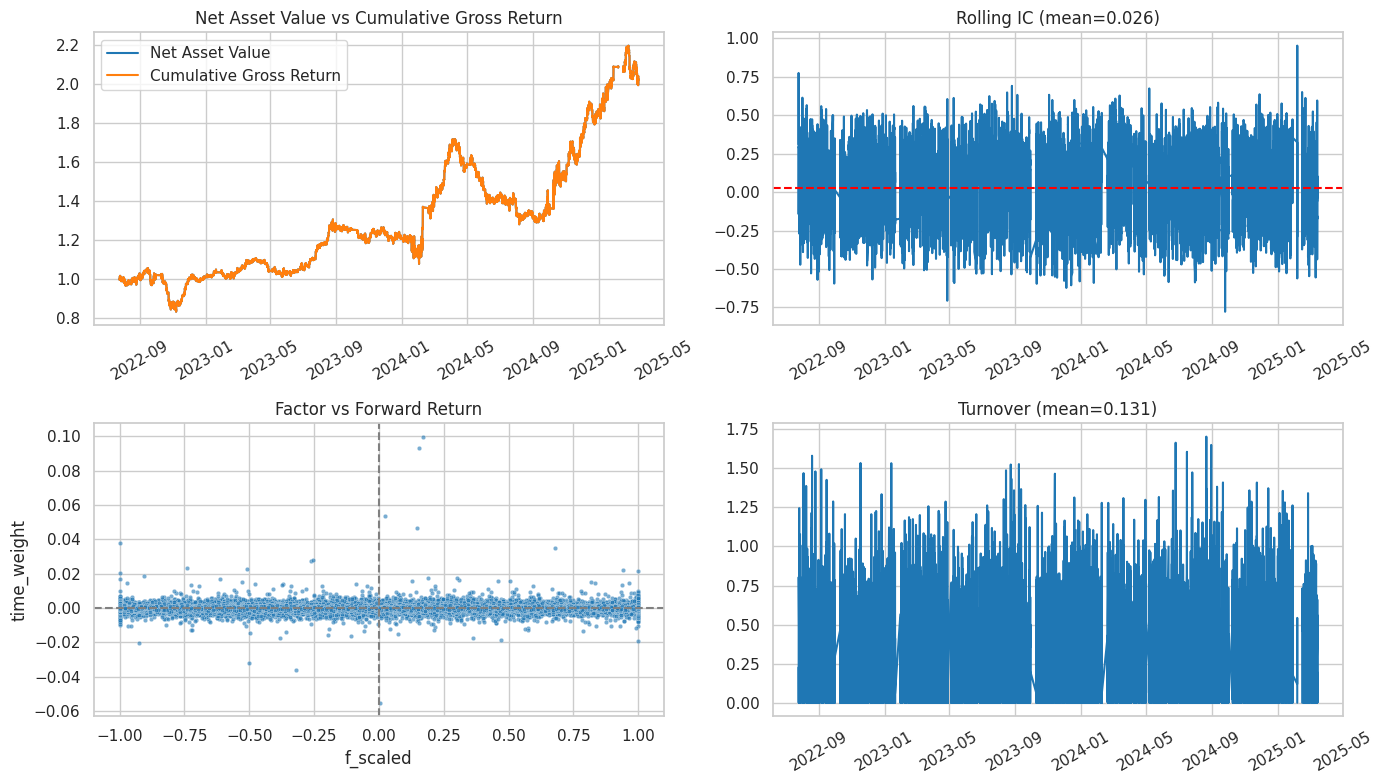

In [13]:
basic_data,perf_data = calc_evaluate(factor_data=factors_data1.merge(total_returns,on=['trade_time','code']), 
                    ret_name='time_weight', roll_win=60, scale_method='roll_min_max', fee=0,
                    is_plot=True)

In [14]:
basic_data

{'total_ret': 1.0224146633318365,
 'avg_ret': 4.824264004028825e-06,
 'max_dd': -0.25455363182908086,
 'calmar': 4.016500004283315,
 'sharpe': 0.12180337163960234,
 'turnover': 0.13148971116852812,
 'win_rate': 0.49702589677653963,
 'profit_ratio': 1.0293056586017806,
 'ic_mean': 0.026474829990421944,
 'ic_std': 0.1978185285976893,
 'ic_ir': 0.13383392434520006}